# Computing the entropy map of a lattice

In [2]:
using Nemo
import AbstractAlgebra
import IterTools
import Polymake

We work over the field of Puiseux series in one variable $t$ with rational coefficients i.e.

$$ K = \mathbb{Q}\{\{t\}\} $$

In [3]:
K, t = PuiseuxSeriesField(QQ, 20, "t")

"""
"normal_form" computes the normal lower triangular representation of a lattice. \n
    \t Input:  A a non singular matrix representing the full rank lattice (A 2d array with Nemo Puiseux series).\n
    \t Output: normal_A a lower triangular matrix representing the same lattice as A.\n
    Example:
                A = Array{AbstractAlgebra.Generic.PuiseuxSeriesFieldElem{fmpq}}([t^0    t^0     t^2    ;
                                                 t^0    t       t^0    ;
                                                 t^0    t^2     t^3   ])
                normalA = normal_form(A)
                julia> indep_A
                3×3 Array{AbstractAlgebra.Generic.PuiseuxSeriesFieldElem{fmpq},2}:
                 1+O(t^10)  0+O(t^10)    0+O(t^10)
                 1+O(t^10)  1+O(t^10)    0+O(t^10)
                 1+O(t^10)  1+t+O(t^10)  1+O(t^10)
"""
function normal_form(A::Array{AbstractAlgebra.Generic.PuiseuxSeriesFieldElem{fmpq}})

    n,d = size(A)

    switch = Array{AbstractAlgebra.Generic.PuiseuxSeriesFieldElem{fmpq}}(undef,n,1)

    for i = 1:n

        j = argmin(valuation.(A[i,i:d])) + i - 1

        switch = A[1:n,i]


        A[1:n,i] = A[1:n,j]
        A[1:n,j] = switch

        val = valuation(A[i,i])
        A[1:n,i] = t^(val) .* (A[1:n,i] .// A[i,i])

        for k = i+1:d
            alpha = - A[i,k]//A[i,i]
            A[1:n,k] = A[1:n,k] + alpha .* A[1:n,i]
        end

    end

    return A[1:n,1:n]

end


"""
"indep_lattice" computes the unique maximal independence lattice of a given lattice. \n
    \t Input:  A a non singular matrix representing the full rank lattice (A 2d array with Nemo Puiseux series).\n
    \t Output: indep_A an array containing the valuations of the diagonal elements of the maximal independence lattice.\n
    Example:
                A = Array{AbstractAlgebra.Generic.PuiseuxSeriesFieldElem{fmpq}}([t^0    t^0     t^2    ;
                                                 t^0    t       t^0    ;
                                                 t^0    t^2     t^3   ])
                indep_A = indep_lattice(A)
                julia> indep_A
                3×1 Array{Rational{Int64},2}:
                0//1
                0//1
                0//1
"""
function indep_lattice(A::Array{AbstractAlgebra.Generic.PuiseuxSeriesFieldElem{fmpq}})

    A = normal_form(A)

    d = size(A)[1]

    indep_A = Array{Rational{Int64}}(undef,d,1)
    indep_A[d] = valuation(A[d,d])

    for i = 1:d-1
        for j = i+1:d

            val = valuation(A[j,j]) - valuation(A[j,i])
            if val >= 0
                A[1:d,i] = t^val .* A[1:d,i]  - (t^val * A[j,i]//A[j,j]) .* A[1:d,j]
            else
                A[1:d,i] = A[1:d,i] - A[j,i]//A[j,j] .*A[1:d,j]

            end

        end

        indep_A[i] = valuation(A[i,i])

    end

    return indep_A

end




"""
"compute_Polynomial" computes the polynomial corresponding to the tropicaliztion of the Gaussian measure. \n
    \t Input:  A a non singular matrix representing the full rank lattice (A 2d array with Nemo Puiseux series).\n
    \t Output: A dictionary of super-modular coefficients (a coefficient for every monomial).\n
    Example:
                 A = Array{AbstractAlgebra.Generic.PuiseuxSeriesFieldElem{fmpq}}([t^0    0t     0t    ;
                                                 t^0    t^2    0t    ;
                                                 t^0    t      t^2   ])
                 julia> compute_Polynomial(A)
                 Dict{Array{Int64,N} where N,Int64} with 8 entries:
                   [1, 3]    => 1
                   [3]       => 0
                   [1, 2, 3] => 4
                   [1, 2]    => 2
                   [1]       => 0
                   [2, 3]    => 1
                   [2]       => 0
                   Int64[]   => 0
"""
function compute_Polynomial(A::Array{AbstractAlgebra.Generic.PuiseuxSeriesFieldElem{fmpq}})

    d = size(A)[1]

    coefs = Dict{Array{Int64},Rational}([]=>0)

    for I in IterTools.subsets(1:d,1)
        B = normal_form(A[I,1:d])
        coefs[I] = valuation(B[1,1])
    end

    for I in IterTools.subsets(1:d,2)
        B = normal_form(A[I,1:d])
        coefs[I] = valuation(B[1,1]) + valuation(B[2,2])
    end


    for k = 2:d

        for I in IterTools.subsets(1:d,k)

            J = I[1:k-1]

            B = normal_form(A[I,1:d])
            coefs[I] = coefs[J] + valuation(B[k,k])

        end

    end

    return coefs

end


"""
Test if a dictionary of coefficients is super-modular.
"""

function IsSupermodular(d::Int64,P::Dict{Array{Int64},Rational})

    bool = true

    for I in IterTools.subsets(1:d)
        for J in IterTools.subsets(1:d)
            K = sort(union(I,J))
            L = sort(intersect(I,J))
            if (P[I] + P[J] > P[K] + P[L])

                bool = false
                break
            end

        end

        if bool == false
            break
        end
    end

    return bool
end



function Print_Polynomial(d::Int64,P::Dict{Array{Int64},Rational})
    for k = 1:d
        println("Size ", k)
        for I in IterTools.subsets(1:d,k)
            println(I, "=========> ", P[I])
        end
        println("\n")
    end
end

function tropical_polynomial(d,P,v)

    m = 0.0

    for I in IterTools.subsets(1:d)
        v_I = 0.0
        for i in I
            v_I = v_I + v[i]
        end

        if m < v_I - P[I]
            m = v_I - P[I]
        end
    end

    return m

end

tropical_polynomial (generic function with 1 method)

  1.034611 seconds (2.64 M allocations: 152.040 MiB, 3.41% gc time, 99.86% compilation time)
Size 1
[1]=========> 0//1
[2]=========> 0//1
[3]=========> 0//1


Size 2
[1, 2]=========> 2//1
[1, 3]=========> 1//1
[2, 3]=========> 1//1


Size 3
[1, 2, 3]=========> 4//1




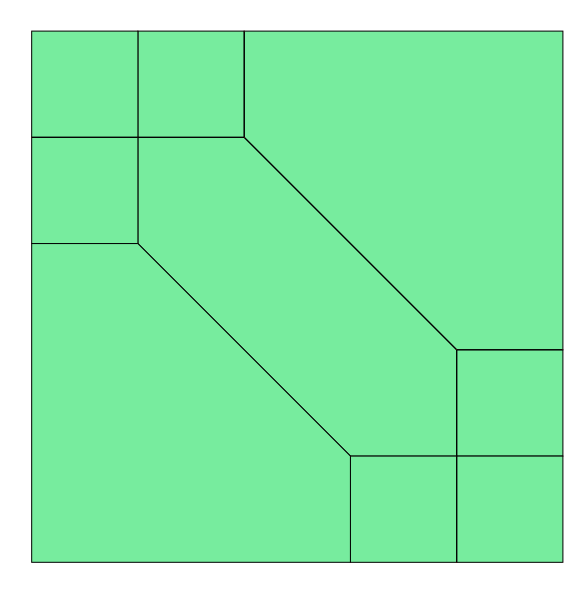

In [4]:
Example1 =  Array{AbstractAlgebra.Generic.PuiseuxSeriesFieldElem{fmpq}}([t^0  0t   0t;
                                                                         t^0  t^2  0t;
                                                                         t^0  t    t^2])


d1 = size(Example1)[1]

@time P1 = compute_Polynomial(Example1)

Print_Polynomial(d1,P1)


# Monomials of the (homogenized) tropical polynomial.

E = [4 0 0 0;
     3 1 0 0;
     3 0 1 0;
     3 0 0 1;
     2 1 1 0;
     2 1 0 1;
     2 0 1 1;
     1 1 1 1]

#Coefficients obtained from the entropy map.
C = [0, Int(- P1[[1]]) , Int(- P1[[2]]) , Int(- P1[[3]]), Int(- P1[[1,2]]), Int(- P1[[1,3]]) , Int(- P1[[2,3]]),  Int( - P1[[1,2,3]]) ];

#Tropical Hypersurface in the Min convention.
V = Polymake.@pm tropical.Hypersurface{Min}(COEFFICIENTS=C, MONOMIALS=E)

#Polymake visualization.
Polymake.visual(V)

In [10]:
Example2 = Array{AbstractAlgebra.Generic.PuiseuxSeriesFieldElem{fmpq}}(
[t^1        0t     0t       0t      0t    0t   0t    0t   0t;
 t^0        t      0t       0t      0t    0t   0t    0t   0t;
 t^1        t^2    t^3      0t      0t    0t   0t    0t   0t;
 t^3        t^3    t^2      t^4     0t    0t   0t    0t   0t;
 t^1        t^2    t^2      t       t^3   0t   0t    0t   0t;
 t^0        t      t^2      t^3     t^4   t^5  0t    0t   0t;
 t^2        t      t+t^2    t^2     t^3   t^2  t^4   0t   0t;
 t^2        t      t+t^2    t^2     t^3   t^2  t^3   t^4  0t ;
 t^2        t      t+t^2    t^2     t^3   t^2  t^3   t^4  t^5])

################################################################################

d2 = size(Example2)[1]

@time P2 = compute_Polynomial(Example2)

Print_Polynomial(d2,P2)



  1.158673 seconds (12.40 M allocations: 575.287 MiB, 46.06% gc time)
Size 1
[1]=========> 1//1
[2]=========> 0//1
[3]=========> 1//1
[4]=========> 2//1
[5]=========> 1//1
[6]=========> 0//1
[7]=========> 1//1
[8]=========> 1//1
[9]=========> 1//1


Size 2
[1, 2]=========> 2//1
[1, 3]=========> 3//1
[1, 4]=========> 3//1
[1, 5]=========> 2//1
[1, 6]=========> 2//1
[1, 7]=========> 2//1
[1, 8]=========> 2//1
[1, 9]=========> 2//1
[2, 3]=========> 3//1
[2, 4]=========> 2//1
[2, 5]=========> 1//1
[2, 6]=========> 2//1
[2, 7]=========> 1//1
[2, 8]=========> 1//1
[2, 9]=========> 1//1
[3, 4]=========> 3//1
[3, 5]=========> 2//1
[3, 6]=========> 4//1
[3, 7]=========> 2//1
[3, 8]=========> 2//1
[3, 9]=========> 2//1
[4, 5]=========> 3//1
[4, 6]=========> 2//1
[4, 7]=========> 3//1
[4, 8]=========> 3//1
[4, 9]=========> 3//1
[5, 6]=========> 1//1
[5, 7]=========> 2//1
[5, 8]=========> 2//1
[5, 9]=========> 2//1
[6, 7]=========> 1//1
[6, 8]=========> 1//1
[6, 9]=========> 1//1
[7, 8]=========> 

[3, 4, 6, 7, 9]=========> 10//1
[3, 4, 6, 8, 9]=========> 12//1
[3, 4, 7, 8, 9]=========> 12//1
[3, 5, 6, 7, 8]=========> 10//1
[3, 5, 6, 7, 9]=========> 10//1
[3, 5, 6, 8, 9]=========> 12//1
[3, 5, 7, 8, 9]=========> 11//1
[3, 6, 7, 8, 9]=========> 13//1
[4, 5, 6, 7, 8]=========> 7//1
[4, 5, 6, 7, 9]=========> 7//1
[4, 5, 6, 8, 9]=========> 9//1
[4, 5, 7, 8, 9]=========> 12//1
[4, 6, 7, 8, 9]=========> 11//1
[5, 6, 7, 8, 9]=========> 10//1


Size 6
[1, 2, 3, 4, 5, 6]=========> 17//1
[1, 2, 3, 4, 5, 7]=========> 14//1
[1, 2, 3, 4, 5, 8]=========> 14//1
[1, 2, 3, 4, 5, 9]=========> 14//1
[1, 2, 3, 4, 6, 7]=========> 15//1
[1, 2, 3, 4, 6, 8]=========> 15//1
[1, 2, 3, 4, 6, 9]=========> 15//1
[1, 2, 3, 4, 7, 8]=========> 14//1
[1, 2, 3, 4, 7, 9]=========> 14//1
[1, 2, 3, 4, 8, 9]=========> 16//1
[1, 2, 3, 5, 6, 7]=========> 12//1
[1, 2, 3, 5, 6, 8]=========> 12//1
[1, 2, 3, 5, 6, 9]=========> 12//1
[1, 2, 3, 5, 7, 8]=========> 11//1
[1, 2, 3, 5, 7, 9]=========> 11//1
[1, 2, 3, 5, 8, 9]===